In [1]:
library(igraph)
library(ggnetwork)
library(magrittr)
library(tidygraph)
library(tidyverse)
library(cowplot)
library(ggrepel)
library(scatterpie)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

theme_set(theme_cowplot() + theme_transparent)
results <- '../results/'
fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')
bim <- read_tsv('~/data/genesis/genesis_2019.bim', col_names = FALSE, col_types = 'icidcc')
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod','All')
palette_yn <- c('Unselected' = 'gray80', 'Selected' = 'firebrick',
                'No' = 'gray80', 'Yes' = 'firebrick')

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GS' = '#fb6a4a',
                    'SConES GM' = '#cb181d', 'SConES GI' = '#67000d',
                    'SigMod' = '#377eb8', 'All' = 'black', 'Consensus' = 'black', 
                    'GENESIS-significant' = '#000080')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2


Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::extract()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        ma

# SF1

In [2]:
evs <- read_tsv(paste0(results,'conventional_gwas/genesis_2019.eigenvec'))

options(repr.plot.width=7.4, repr.plot.height=7.5)
pc1_2 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC2, PC1, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc3_4 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC4, PC3, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc5_6 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC6, PC5, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc7_8 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC8, PC7, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

sf1 <- plot_grid(pc1_2, pc3_4, pc5_6, pc7_8, labels = c('A','B','C','D'))

Parsed with column specification:
cols(
  .default = col_double(),
  IID = col_character()
)

See spec(...) for full column specifications.



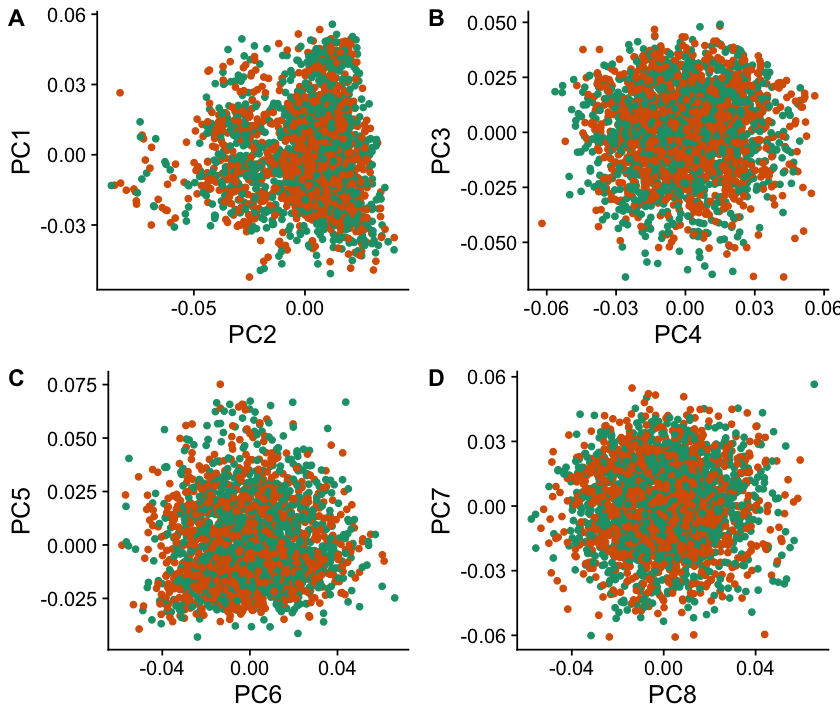

In [3]:
options(repr.plot.width=7, repr.plot.height=6)
sf1
ggsave('figures/sfigure_1.pdf', sf1, width=7, height=6, bg = "transparent")

# SF2: GENESIS Manhattan plot

In [4]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
sf2a <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(gene)) %>% 
                          group_by(gene) %>% 
                          summarise(P = min(P), BPcum = BPcum[which.min(P)]), 
              aes(x=BPcum, y=-log10(P), label = gene), size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)')) +
    theme_transparent

In [5]:
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
sf2b <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(Gene)), 
              aes(x=BPcum, y=-log10(`Top-0.1-pvalue`), label = Gene), 
              size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)')) +
    theme_transparent

In [6]:
lasso_snps <- read_tsv(paste0(results, 'lasso/scored_snps.lasso.tsv'), col_types = 'cd', comment = '#') %>%
    filter(beta != 0) %>%
    .$snp

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(snp %in% lasso_snps, 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
sf2c <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)')) +
    theme_transparent

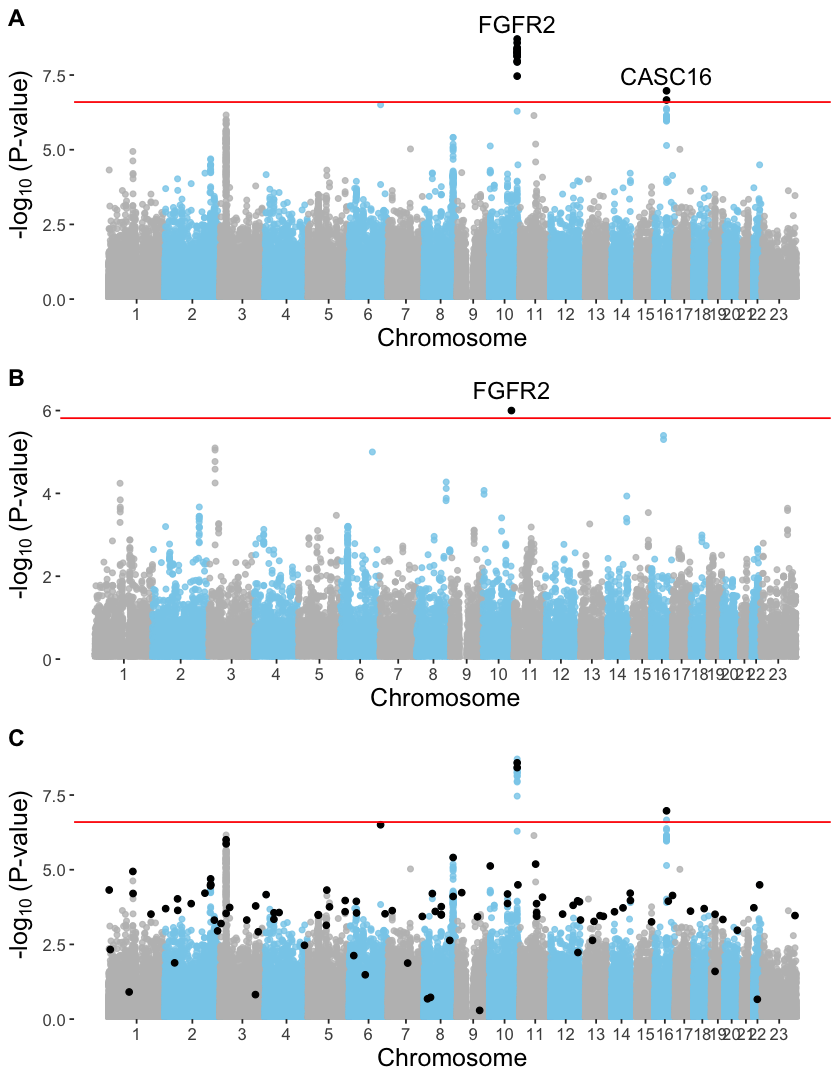

In [7]:
options(repr.plot.width=7, repr.plot.height=9)
sf2 <- plot_grid(sf2a, sf2b, sf2c, labels = c('A', 'B', 'C'), nrow = 3)
sf2
ggsave('figures/sfigure_2.pdf', sf2, width=7, height=9, bg = "transparent")
ggsave('figures/sfigure_2.png', sf2, width=7, height=9, bg = "transparent")

# SF3: Heterogeneity (all methods, genes and SNPs)

In [8]:
methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd')
all_genes <- unique(vegas$Gene)

dmgwas <- all_genes %in% (read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene)
heinz <- all_genes %in% (read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene)
hotnet2 <- all_genes %in% (read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene)
lean <- all_genes %in% (read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene)
sigmod <- all_genes %in% (read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene)
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gs <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gm <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gi <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)

bms <- list(dmgwas, heinz, hotnet2, lean, scones_gs, scones_gm, scones_gi, sigmod)
pearson_gene <- lapply(bms, function(x) 
            lapply(bms, cor, x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, corr, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           corr = round(as.numeric(corr), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = 0.5)) +
        theme_transparent

all_snps <- bim$X2

dmgwas <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene])
heinz <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene])
hotnet2 <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene])
lean <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% (read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>% .$Gene)])
sigmod <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene])
scones_gs <- all_snps %in% (read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp %>%
    unique)
scones_gm <- all_snps %in% (read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp %>%
    unique)
scones_gi <- all_snps %in% (read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp %>%
    unique)

bms <- list(dmgwas, heinz, hotnet2, lean, scones_gs, scones_gm, scones_gi, sigmod)
pearson_snp <- lapply(bms, function(x) 
            lapply(bms, cor, x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, corr, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           corr = round(as.numeric(corr), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = 0.5)) +
        theme_transparent
                   
sf3 <- plot_grid(pearson_gene, pearson_snp, labels = c('A','B'))

Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in F

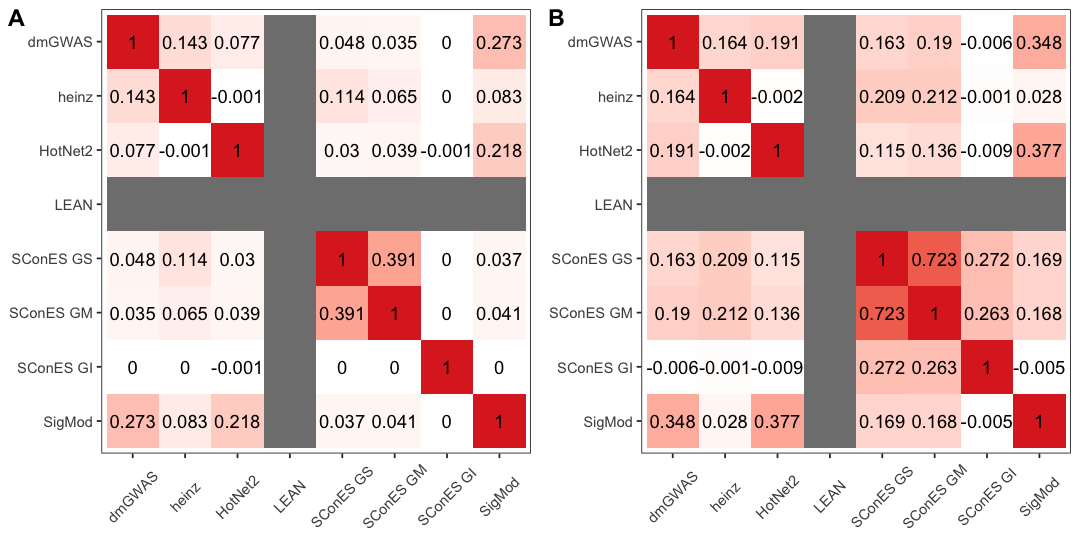

In [9]:
options(repr.plot.width=9, repr.plot.height=4.5)
sf3
ggsave('figures/sfigure_3.pdf', sf3, width=9, height=4.5, bg = "transparent")

# SF4: consensus network

In [10]:
cols_methods <- c('dmGWAS','heinz','HotNet2','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)

ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))

set.seed(0)
consensus_nodes <- read_tsv(paste0(results,'consensus/consensus.tsv'), 
                            col_types = 'cdidlllllli')

consensus <- inner_join(ppi, consensus_nodes, by = c('name' = 'gene', 'p'))
class(consensus) <- 'igraph'

consensus <- consensus %>%
    ggnetwork %>%
    mutate(name = as.character(name))

nodes <- mutate(consensus, dmGWAS = as.numeric(dmgwas),
                heinz = as.numeric(heinz),
                HotNet2 = as.numeric(hotnet2),
                `SConES GI` = as.numeric(scones_gi),
                SigMod = as.numeric(sigmod),
                radius = ifelse(known, 0.03, 0.02)) %>%
    filter(xend == x & yend == y) %>% 
    select(x, y, name, radius, p, known, cols_methods) %>%
    unique
edges <- filter(consensus, xend != x | yend != y)

consensus_pies <- ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = 'grey80', size = 1.2) +
    geom_scatterpie(data = nodes, aes(x = x, y = y, r = radius), cols = cols_methods) +
    geom_label_repel(data = filter(nodes, p < 0.001 | known), 
                     aes(x = x, y = y, label = name, color = known), 
                     nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
                     hjust = 0.5, vjust = 0.5, size = 2) + 
    coord_fixed() +
    theme_blank() +
    labs(fill = 'Method') +
    scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
    scale_fill_manual(values = method_palette) +
    guides(color = FALSE) +
    theme(legend.position = 'left') +
    theme_transparent

consensus_names <- ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = 'grey80', size = 1.2) +
    geom_point(data = nodes, aes(x = x, y = y, color = known), size = 3) + 
    geom_label_repel(data = nodes, aes(x = x, y = y, label = name, color = known), size = 2) + 
    coord_fixed() +
    theme_blank() +
    labs(fill = 'Method') +
    scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
    scale_fill_manual(values = method_palette) +
    guides(color = FALSE) +
    theme(text = element_text(size = 7)) +
    theme_transparent

sf4 <- plot_grid(consensus_pies, consensus_names, 
                           labels = c('A','B'), rel_heights = c(1,1.5), nrow = 2)

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(cols_methods)` instead of `cols_methods` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



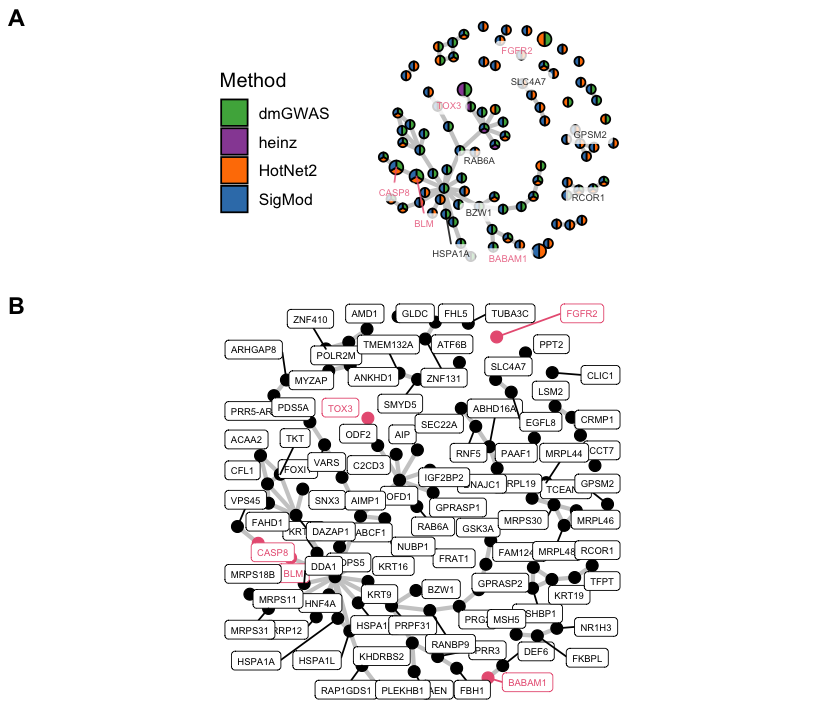

In [11]:
options(repr.plot.width=7, repr.plot.height=6)
sf4
ggsave('figures/sfigure_4.pdf', sf4, width=7, height=6, bg = "transparent")

# SF5: consensus network stats

In [12]:
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidlllllli')
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweeness = centrality_betweenness())
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

bwness_box <- ppi %>%
    mutate(in_consensus = ifelse(name %in% consensus$gene, 'Yes', 'No'),
           cancer_gene = name %in% known_brca_genes) %>%
    as_tibble %>%
    ggplot(aes(x = in_consensus, y = betweeness, fill = cancer_gene)) +
        geom_boxplot(outlier.colour = NA) +
        scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50')) +
        scale_y_continuous(limits = c(0, 1e+5)) +
        labs(x = 'In consensus network', y = 'Betweeness centrality') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title = element_text(size = 11))

num_methods_assoc <- ggplot(consensus, aes(x = as.character(num_methods), y = -log10(p))) +
    geom_boxplot() +
    scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50')) +
    labs(x = 'Number of methods', y = bquote('-log'[10]~'(P-value)')) +
    theme(legend.position = 'none',
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11))

hist_num_methods <- arrange(consensus, num_methods) %>%
    mutate(gene = factor(gene, levels = gene)) %>%
    ggplot(aes(x = gene, y = num_methods, 
               fill = ifelse(known, 'Yes','No'))) +
        geom_bar(stat = 'identity') +
        coord_flip() +
        scale_fill_manual(values = c('Yes' = '#ff96a7', 'No' = 'gray50')) +
        labs(x = 'Gene', y = 'Number of methods', fill = 'Familial BC gene') +
        theme(legend.position = 'none',
              axis.text = element_text(size = 7),
              axis.title = element_text(size = 11),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 11))

centrality_assoc <- ggplot(consensus, aes(y = -log10(p), x = log10(betweenness))) +
    geom_point(aes(color = known)) +
    geom_smooth(method = "glm") +
    labs(x = bquote('log'[10]~'(Betweenness centrality)'), 
         y = bquote('-log'[10]~'(P-value)')) +
    theme(legend.position = 'none',
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11)) +
    scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50'))

legend <- get_legend(hist_num_methods + theme(legend.position = 'bottom',
                                              legend.justification = 'center'))

sf5 <- plot_grid(plot_grid(hist_num_methods,
                           plot_grid(num_methods_assoc, bwness_box, centrality_assoc,
                                     labels = c('B','C','D'), nrow = 3),
                           ncol = 2, labels = 'A'),
                 legend, nrow = 2, rel_heights = c(10,1))

Warning message:
“Removed 409 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


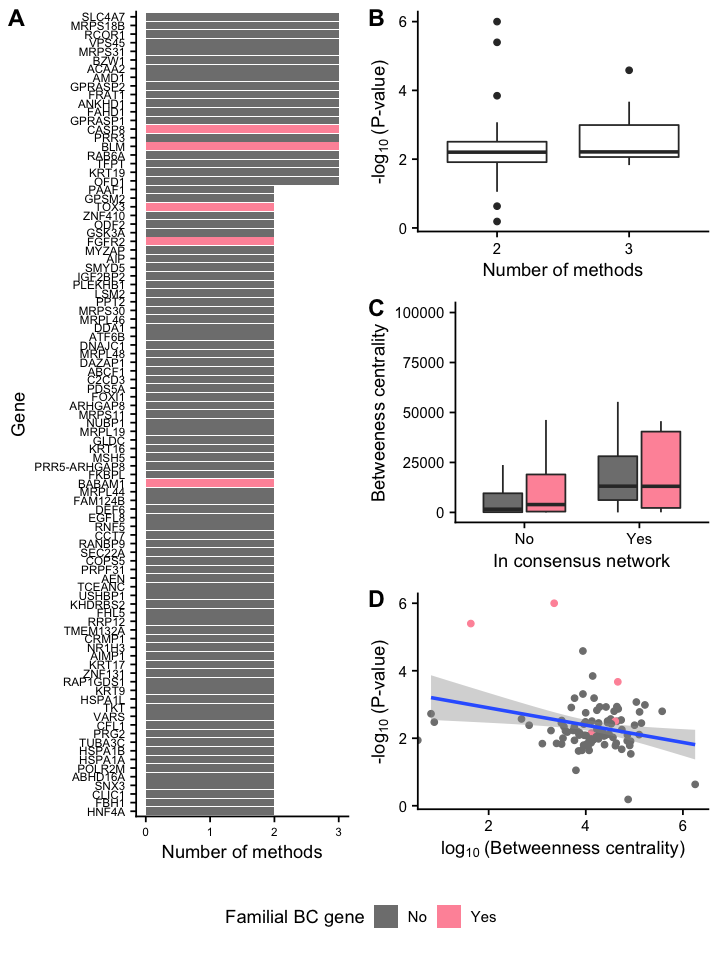

In [13]:
options(repr.plot.width=6, repr.plot.height=8)
sf5
ggsave('figures/sfigure_5.pdf', sf5, width=6, height=8, bg = "transparent")

# SF6: 

In [14]:
hgnc <- read_tsv(paste0(results,'preprocessing/non_alt_loci_set.txt'), 
                 col_types = cols(.default = "c")) %>%
    select(symbol, ensembl_gene_id)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = "c")) %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
gene_types <- read_tsv(paste0(results,'bad_genes/gencode.v31.annotation.gff3'), comment = '#', 
                       col_names = FALSE, col_types = cols(.default = "c")) %>%
    filter(X3 == 'gene') %>%
    select(X9) %>%
    mutate(X9 = gsub('ID=', '', X9),
           X9 = gsub('\\.[0-9]+;gene_id.+gene_type=', ';', X9),
           X9 = gsub(';gene_name.+', '', X9)) %>%
    separate(X9, into = c('ensembl_gene_id','type'), sep = ';') %>%
    inner_join(hgnc, by = "ensembl_gene_id")

genes_icogs <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')$gene %>% unique
genes_hint <- as_tibble(ppi)$name

sf6 <- filter(gene_types, symbol %in% setdiff(genes_icogs, genes_hint)) %>%
    mutate(type = gsub('_', ' ', type),
           type = ifelse(grepl(' ', type), tools::toTitleCase(type), type)) %>%
    group_by(type) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(type = factor(type, levels = type)) %>%
    ggplot(aes(x = type, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene type', y = 'Counts') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

Warning message:
“Expected 2 pieces. Additional pieces discarded in 45 rows [60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, ...].”


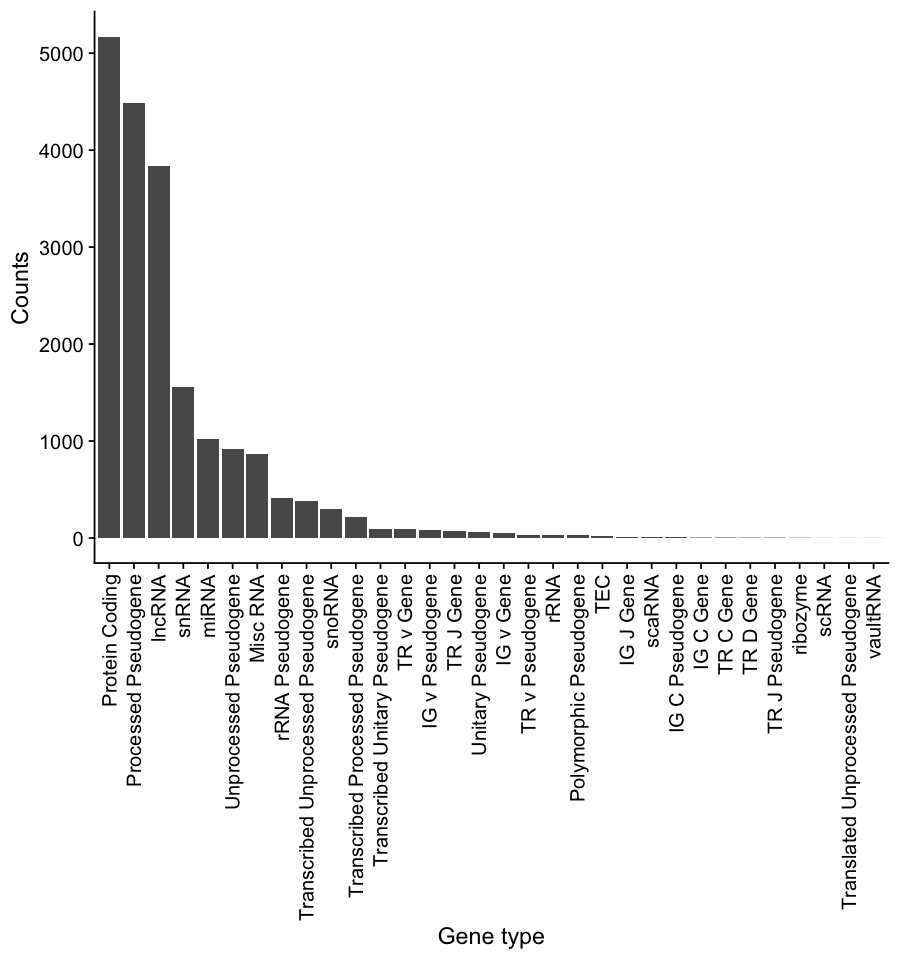

In [15]:
options(repr.plot.width=7.5, repr.plot.height=8)
sf6
ggsave('figures/sfigure_6.pdf', sf6, width=7, height=6, bg = "transparent")

# SF7: HT vs. (HT + LC)

In [16]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GI' = '#cb181d',
                    'SigMod' = '#377eb8', 'All' = 'black')

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method))
stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)))                                     
time_ht <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           time_s = parse_deltatime(realtime),
           alg_time_s = parse_deltatime(realtime),
           tot_time_s = alg_time_s + mean(alg_time_s[method == 'vegas']),
           tot_time_s = ifelse(grepl('SConES', method), alg_time_s, tot_time_s),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene'),
           method = factor(method, levels = rev(methods))) %>%
    filter(!is.na(method))

pred_lc <- read_tsv(paste0(results,'lc_ht_network/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method))
stab_lc <- read_tsv(paste0(results,'lc_ht_network/stability.tsv'), col_types = 'cicd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)))
time_lc <- read_tsv(paste0(results,'lc_ht_network/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           time_s = parse_deltatime(realtime),
           alg_time_s = parse_deltatime(realtime),
           tot_time_s = alg_time_s + mean(alg_time_s[method == 'vegas']),
           tot_time_s = ifelse(grepl('SConES', method), alg_time_s, tot_time_s),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene'),
           method = factor(method, levels = rev(methods))) %>%
    filter(!is.na(method))

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [64, 110].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [64, 110].”


In [17]:
sel_act <- inner_join(group_by(pred_lc, method) %>%
                           summarize(n_selected = mean(n_selected),
                                     n_active = mean(n_active_set)),
                       group_by(pred_ht, method) %>%
                           summarize(n_selected = mean(n_selected),
                                     n_active = mean(n_active_set)),
                       by = 'method', suffix = c('_lc','_ht')) %>%
    filter(! method %in% c('All', 'SConES GS', 'SConES GM')) %>%
    group_by(method) %>%
    filter(method != 'All') %>%
    summarize(delta_selected = n_selected_lc/n_selected_ht,
              delta_active = n_active_lc/n_active_ht) %>%
    ggplot(aes(x = delta_selected, y = delta_active, 
               label = method, color = method)) +
        geom_point() +
        geom_hline(yintercept = 1, color = 'gray') +
        geom_vline(xintercept = 1, color = 'gray') +
        geom_text_repel(size = 3) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Ratio selected', y = 'Ratio active') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11))

sens_spec <- inner_join(group_by(pred_lc, method) %>%
                            summarize(sensitivity = mean(sensitivity),
                                      specificity = mean(specificity)),
                        group_by(pred_ht, method) %>%
                            summarize(sensitivity = mean(sensitivity),
                                      specificity = mean(specificity)),
                        by = 'method', suffix = c('_lc','_ht')) %>%
    filter(! method %in% c('All', 'SConES GS', 'SConES GM')) %>%
    group_by(method) %>%
    summarize(delta_sensitivity = sensitivity_ht - sensitivity_lc,
              delta_specificity = specificity_ht - specificity_lc) %>%
    ggplot(aes(x = delta_sensitivity, y = delta_specificity, 
               label = method, color = method)) +
        geom_point() +
        geom_hline(yintercept = 0, color = 'gray') +
        geom_vline(xintercept = 0, color = 'gray') +
        geom_text_repel(size = 3) +
        scale_color_manual(values = method_palette) +
        labs(x = expression(paste(Delta, ' sensitivity')),
             y = expression(paste(Delta, ' specificity'))) +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11))

jacc <- inner_join(group_by(stab_lc, method) %>%
                            summarize(pearson = mean(pearson)),
                        group_by(stab_ht, method) %>%
                            summarize(pearson = mean(pearson)),
                        by = 'method', suffix = c('_lc','_ht')) %>%
    filter(! method %in% c('All', 'SConES GS', 'SConES GM')) %>%
    group_by(method) %>%
    summarize(delta_pearson = pearson_ht - pearson_lc) %>%
    ggplot(aes(x = delta_pearson, y = method, color = method)) +
        geom_point() +
        geom_vline(xintercept = 0, color = 'gray') +
        labs(x = expression(paste(Delta, ' correlation'))) +
        scale_color_manual(values = method_palette) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.y = element_text(size = 9),
              axis.text.x = element_text(size = 9),
              axis.title.x = element_text(size = 11))

time <- inner_join(group_by(time_lc, method, type) %>%
                       summarize(alg_time_s = mean(alg_time_s),
                                 tot_time_s = mean(tot_time_s)),
                   group_by(time_ht, method, type) %>%
                       summarize(alg_time_s = mean(alg_time_s),
                                 tot_time_s = mean(tot_time_s)),
                   by = c('method','type'), suffix = c('_lc','_ht')) %>%
    group_by(method, type) %>%
    summarize(ratio_alg_time_s = alg_time_s_lc / alg_time_s_ht,
              ratio_tot_time_s = tot_time_s_lc / tot_time_s_ht) %>%
    select(method, ratio_alg_time_s, ratio_tot_time_s, type) %>%
    gather(time_type, ratio_time_s, -type, -method) %>%
    filter(!(method == 'SConES GI' & time_type == 'ratio_alg_time_s')) %>%
    filter(! method %in% c('All', 'SConES GS', 'SConES GM')) %>%
    ggplot(aes(x = ratio_time_s, y = method, fill = method, size = time_type, shape = time_type)) +
        geom_point(color = 'black') +
        geom_vline(xintercept = 1, color = 'gray') +
        labs(x = expression(paste(Delta, ' time (s)'))) +
        scale_fill_manual(values = method_palette) +
        scale_shape_manual(values=c('ratio_alg_time_s' = 25, 'ratio_tot_time_s' = 21)) +
        scale_size_manual(values=c('ratio_alg_time_s' = 1.5, 'ratio_tot_time_s' = 3)) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.y = element_text(size = 9),
              axis.text.x = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="gray90")) +
        facet_grid(type ~ ., scales = 'free', space = 'free')

sf7 <- plot_grid(sel_act, sens_spec, jacc, time, nrow = 2, labels = c('A','B','C','D'))

Warning message:
“Factor `method` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `method` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `method` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


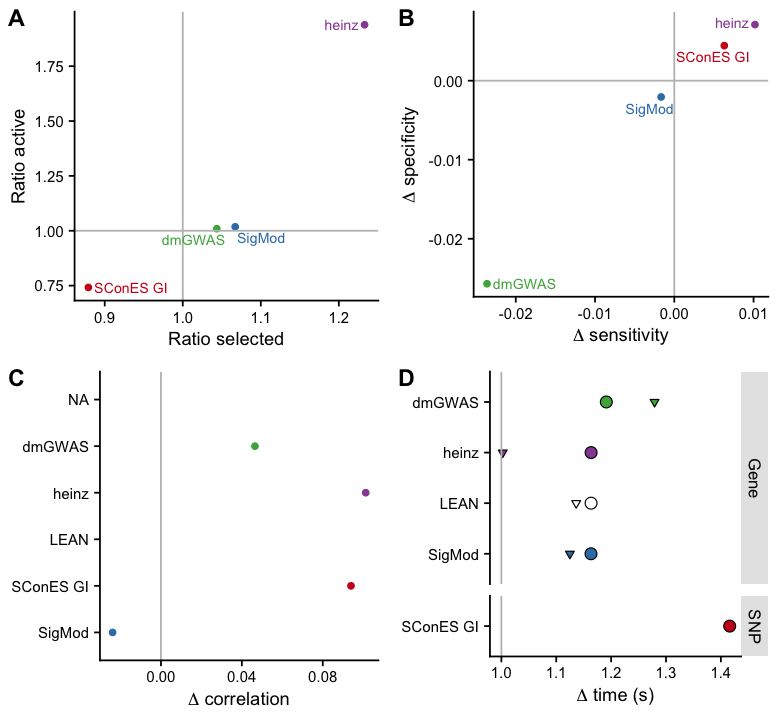

In [18]:
options(repr.plot.width=6.5, repr.plot.height=6)
sf7
ggsave('figures/sfigure_7.pdf', sf7, width=6.5, height=6, bg = "transparent")

# SF8: SConES GS and GM comparisons

In [19]:
method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GS' = '#fb6a4a',
                    'SConES GM' = '#cb181d', 'SConES GI' = '#67000d',
                    'SigMod' = '#377eb8', 'All' = 'black', 'Consensus' = 'black', 
                    'GENESIS-significant' = '#000080')

In [20]:
gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

snp_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 10),
      axis.text = element_text(size = 8),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(SNP P-value)')) +
    theme_transparent

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
gs_mh <- snp_manhattan + geom_point(data = filter(don, snp %in% scones_gs), aes(x=BPcum, y=-log10(P)), color = 'black')

scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
gm_mh <- snp_manhattan + geom_point(data = filter(don, snp %in% scones_gm), aes(x=BPcum, y=-log10(P)), color = 'black')

In [21]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected, title) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No'),
           selected = ifelse(SNP %in% selected, 'Selected', 'Unselected'),
           selected = factor(selected, levels = c('Unselected','Selected'))) %>%
    select(selected, sign_bcac) %>%
    gather(where, sign, -selected) %>%
    ggplot(aes(x = sign, fill = selected)) +
        geom_bar(position = 'fill') +
        labs(fill = '', y = 'Fraction', x = 'BCAC significant SNP', title = title) +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        theme(legend.position = 'none',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10)) +
        theme_transparent
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_bcac <- plot_selected_snps(snps, gs, '')

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_bcac <- plot_selected_snps(snps, gm, '')

In [22]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected, title) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No'),
           selected = ifelse(SNP %in% selected, 'Selected', 'Unselected'),
           selected = factor(selected, levels = c('Unselected','Selected'))) %>%
    select(selected, sign_genesis) %>%
    gather(where, sign, -selected) %>%
    ggplot(aes(x = sign, fill = selected)) +
        geom_bar(position = 'fill') +
        labs(fill = '', y = 'Fraction', x = 'GENESIS significant SNP', title = title) +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        theme(legend.position = 'none',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10)) +
        theme_transparent
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_genesis <- plot_selected_snps(snps, gs, '')

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_genesis <- plot_selected_snps(snps, gm, '')

In [23]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis')) %>%
    filter(Gene %in% genes_in_ppi)

plot_selected_genes <- function(genes, selected, method) {
    
    known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                                 col_types = 'ccciccciddddcddddd')$Gene
    
    genes %>%
        mutate(bc_gene = ifelse(Gene %in% known_brca_genes, 'Yes', 'No'),
               selected = ifelse(Gene %in% selected, 'Selected', 'Unselected'),
               selected = factor(selected, levels = c('Unselected','Selected'))) %>%
        select(selected, bc_gene) %>%
        ggplot(aes(x = bc_gene, fill = selected)) +
            geom_bar(position = 'fill') +
            labs(y = 'Fraction', x = 'Familial BC gene',  
                 fill = 'Selected gene', title = method) +
            theme_bw() +
            scale_fill_manual(values = palette_yn) +
            theme(legend.position = 'none',
                  axis.text = element_text(size = 8),
                  axis.title = element_text(size = 10),
                  strip.text = element_text(size = 10)) +
            theme_transparent
    
}

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene
gs_bc <- plot_selected_genes(genes, scones_gs, '')

scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene
gm_bc <- plot_selected_genes(genes, scones_gm, '')

legend <- cowplot::get_legend(gm_bc + theme(legend.position="bottom"))

In [24]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    filter(Gene %in% genes_in_ppi) %>%
    rename(P = `Top-0.1-pvalue`,
           marker = Gene) %>%
    select(marker, P)

# scones comparison
snps <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd') %>%
    rename(marker = SNP) %>%
    select(marker, P)

get_precision_recall <- function(genes, selected, method, bonf) {
    
    genes %>%
        mutate(sign = P < bonf,
               selected = marker %in% selected) %>%
        summarize(precision = sum(selected & sign)/sum(selected),
                  recall = sum(selected & sign)/sum(sign)) %>%
        mutate(method = method)
    
}

genesis_sign <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd')  %>%
    filter(P < (.05/n()) ) %>%
    .$SNP
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidlllllli')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc', 
         comment = '#', col_names = F) %>%
    select(X1) %>%
    separate_rows(X1, sep = ' ') %>%
    .$X1
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp

gs_gm_genesis <- bind_rows(get_precision_recall(genes, consensus, 'Consensus', .05 / nrow(genes)),
                 get_precision_recall(genes, lean, 'LEAN', .05 / nrow(genes)),
                 get_precision_recall(genes, sigmod, 'SigMod', .05 / nrow(genes)),
                 get_precision_recall(genes, dmgwas, 'dmGWAS', .05 / nrow(genes)),
                 get_precision_recall(genes, hotnet2, 'HotNet2', .05 / nrow(genes)),
                 get_precision_recall(snps, gs, 'SConES GS', .05 / nrow(snps)),
                 get_precision_recall(snps, gm, 'SConES GM', .05 / nrow(snps)),
                 get_precision_recall(snps, gi, 'SConES GI', .05 / nrow(snps))) %>%
    ggplot(aes(precision, recall, color = method, label = method)) +
        geom_point() +
        geom_text_repel() +
        labs(x = 'Precision', y = 'Recall', title = 'GENESIS') + 
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = method_palette) +
        theme(legend.position = 'none',
              text = element_text(size = 10),
              axis.title = element_text(size = 15))

In [25]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes_in_genesis <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd') %>%
    .$Gene
genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    filter(Gene %in% genes_in_ppi & Gene %in% genes_in_genesis) %>%
    rename(P = `Top-0.1-pvalue`,
           marker = Gene) %>%
    select(marker, P)

# scones comparison
snps_genesis <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd') %>%
    .$SNP
snps <- read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                 col_types = 'icdcddcddd') %>%
    filter(SNP %in% snps_genesis) %>%
    rename(marker = SNP) %>%
    select(marker, P)

get_precision_recall <- function(genes, selected, method, bonf) {
    
    genes %>%
        mutate(sign = P < bonf,
               selected = marker %in% selected) %>%
        summarize(precision = sum(selected & sign)/sum(selected),
                  recall = sum(selected & sign)/sum(sign)) %>%
        mutate(method = method)
    
}

genesis_sign <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd')  %>%
    filter(P < (.05/n()) ) %>%
    .$SNP
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidlllllli')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc', 
         comment = '#', col_names = F) %>%
    select(X1) %>%
    separate_rows(X1, sep = ' ') %>%
    .$X1
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp

gs_gm_bcac <- bind_rows(get_precision_recall(snps, genesis_sign, 'GENESIS-significant', .05 / nrow(snps)),
          get_precision_recall(genes, consensus, 'Consensus', .05 / nrow(genes)),
          get_precision_recall(genes, lean, 'LEAN', .05 / nrow(genes)),
          get_precision_recall(genes, sigmod, 'SigMod', .05 / nrow(genes)),
          get_precision_recall(genes, dmgwas, 'dmGWAS', .05 / nrow(genes)),
          get_precision_recall(genes, hotnet2, 'HotNet2', .05 / nrow(genes)),
          get_precision_recall(snps, gs, 'SConES GS', .05 / nrow(snps)),
          get_precision_recall(snps, gm, 'SConES GM', .05 / nrow(snps)),
          get_precision_recall(snps, gi, 'SConES GI', .05 / nrow(snps))) %>%
    ggplot(aes(precision, recall, color = method, label = method)) +
        geom_point() +
        geom_text_repel() +
        labs(x = 'Precision', y = 'Recall', title = 'BCAC') + 
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = method_palette) +
        theme(legend.position = 'none',
              text = element_text(size = 10),
              axis.title = element_text(size = 15))

In [26]:
# GENE comparison
# use only genes that can be found in the PPIN
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

get_precision_recall <- function(selected, method) {
    
    selected <- unique(selected)
    
    tibble(precision = length(intersect(selected, known_brca_genes)) / length(selected),
           recall = length(intersect(selected, known_brca_genes)) / length(known_brca_genes),
           method = method)
    
}

genesis_sign <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd')  %>%
    filter(P < (.05/n()) ) %>%
    inner_join(snp2gene, by = c('SNP' = 'snp')) %>%
    select(gene) %>%
    .$gene
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidlllllli')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc', 
         comment = '#', col_names = F) %>%
    select(X1) %>%
    separate_rows(X1, sep = ' ') %>%
    .$X1
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene

gs_gm_disgenet <- bind_rows(get_precision_recall(genesis_sign, 'GENESIS-significant'),
                 get_precision_recall(consensus, 'Consensus'),
                 get_precision_recall(lean, 'LEAN'),
                 get_precision_recall(sigmod, 'SigMod'),
                 get_precision_recall(dmgwas, 'dmGWAS'),
                 get_precision_recall(hotnet2, 'HotNet2'),
                 get_precision_recall(gs, 'SConES GS'),
                 get_precision_recall(gm, 'SConES GM'),
                 get_precision_recall(gi, 'SConES GI')) %>%
    ggplot(aes(precision, recall, color = method, label = method)) +
        geom_point() +
        geom_text_repel() +
        labs(x = 'Precision', y = 'Recall', title = 'DisGeNET') + 
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = method_palette) +
        theme(legend.position = 'none',
              text = element_text(size = 10),
              axis.title = element_text(size = 15))

In [27]:
plot_network <- function(net, selected_nodes) {
    
    graph <- activate(net, nodes) %>%
        filter(name %in% selected_nodes)
    class(graph) <- c('igraph','tbl_graph')
    
    ggnetwork(graph) %>%
        mutate(name = as.character(name)) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(color = 'gray20') +
            geom_nodes(color = 'gray20') +
            theme_blank() + theme_transparent + 
            theme(title = element_text(hjust = 1, face = 'bold'))
}

load(paste0(results,'scones/gs_network.betweenness.RData'))
scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gs_plt <- plot_network(gs_net, scones_gs) + 
    labs(title = 'SConES GS')

load(paste0(results,'scones/gm_network.betweenness.RData'))
scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gm_plt <- plot_network(gm_net, scones_gm) + 
    labs(title = 'SConES GM')

In [28]:
sf8 <- plot_grid(plot_grid(gs_mh, gm_mh, labels = c('SConES GS','SConES GM')), 
                  plot_grid(scones_gs_plt, scones_gm_plt),
                  plot_grid(gs_gm_genesis, gs_gm_bcac, gs_gm_disgenet, ncol = 3),
                  labels = c('A','B','C'),
                  nrow = 3, rel_widths = c(1,2,1))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”


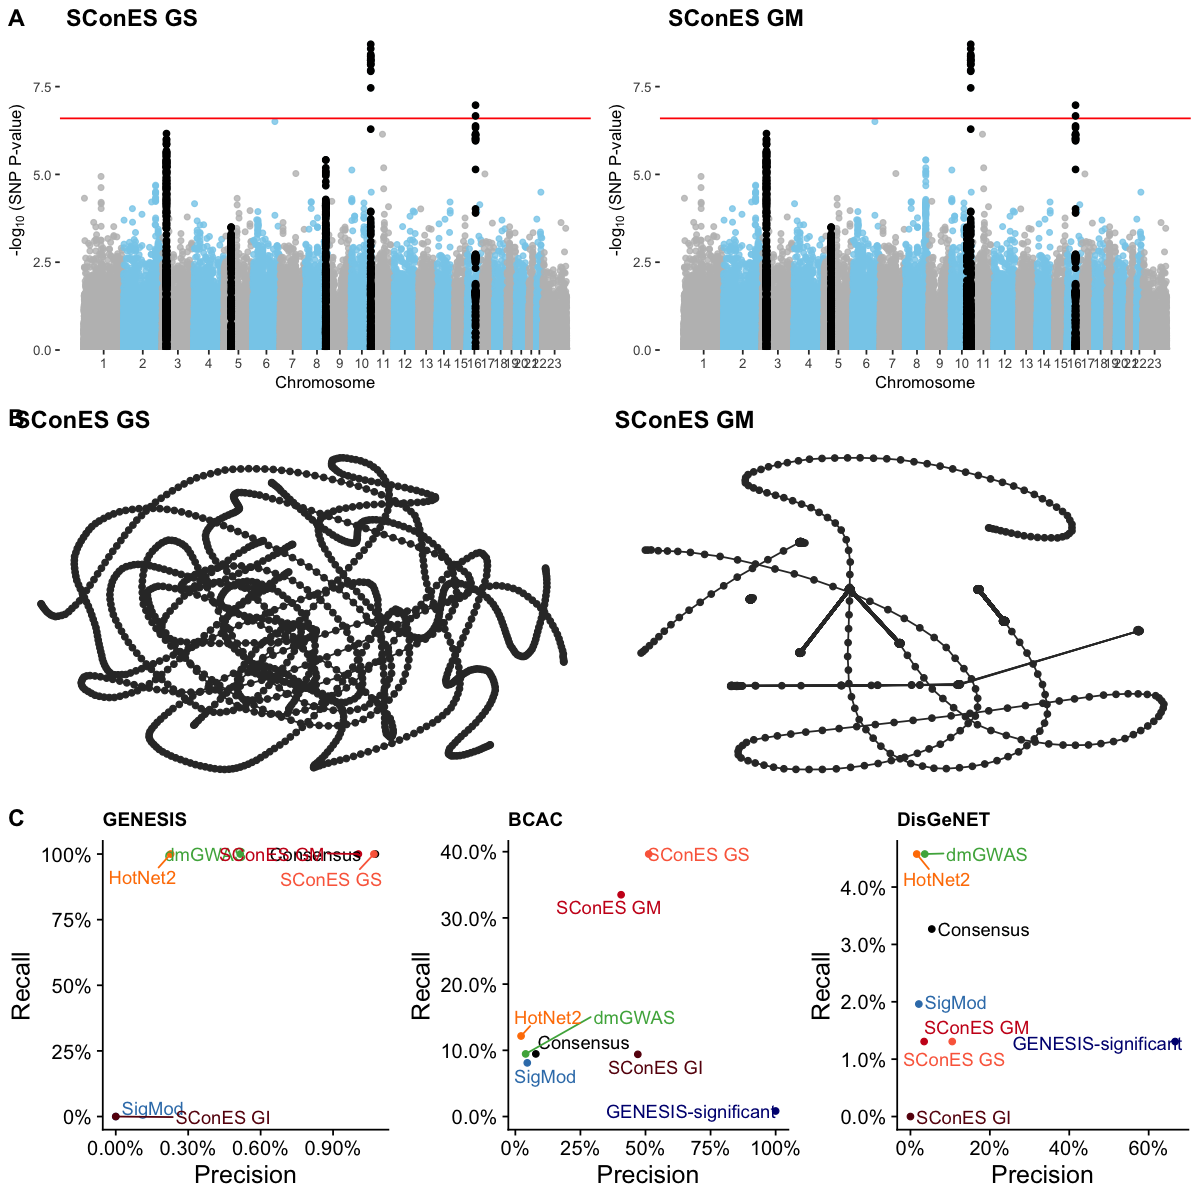

In [29]:
options(repr.plot.width=10, repr.plot.height=10)
sf8
ggsave('figures/sfigure_8.pdf', sf8, width=10, height=10, bg = "transparent")
ggsave('figures/sfigure_8.png', sf8, width=10, height=10, bg = "transparent")